In [ ]:
#set the colab to access the google drive
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("drive/MyDrive/Colab Notebooks/CoV_Encoder")

Mounted at /content/drive/


In [ ]:
#import package
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.layers import Concatenate

%matplotlib inline

In [ ]:
# Read a file and split into train,validation,test sets

data_path = 'data/RBD-HA_new_full_CDR.xlsx'
raw_df = pd.read_excel(data_path)
raw_df=raw_df[raw_df[['CDRH1_AA','CDRL1_AA','CDRH2_AA','CDRL2_AA','CDRH3_AA','CDRL3_AA']].notnull().all(1)]
cleaned_df = raw_df[['Name','cluster','Antigen','Resources','CDRH1_AA','CDRL1_AA','CDRH2_AA','CDRL2_AA','CDRH3_AA','CDRL3_AA','VH Genbank ID','VL Genbank ID']].copy()

#deduplication
cleaned_df = cleaned_df.drop_duplicates(subset=['CDRH1_AA','CDRL1_AA','CDRH2_AA','CDRL2_AA','CDRH3_AA','CDRL3_AA'])

# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# # Over sampling for training set HA Abs
# S_train_df = train_df[train_df.Antigen == 'Spike']
# S_num = len(S_train_df)
# HA_train_df = train_df[train_df.Antigen == 'HA']
# print(HA_train_df)
# HA_train_df=HA_train_df.sample(S_num, replace=True) 
# print(HA_train_df)
# train_df = pd.concat([S_train_df,HA_train_df])

print(len(train_df))
print(len(val_df))
print(len(test_df))


2963
741
927


In [ ]:
# save train_df, val_df, test_df
train_df['dataset']='train set'
val_df['dataset']='val set'
test_df['dataset']='test set'
dataset_df = df=pd.concat([train_df,val_df,test_df])
dataset_df.to_csv('result/dataset/RBD_new_dataset.csv')


# Data processing

In [ ]:

codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1

  return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [ ]:
def integer_encoding(data,CDR):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rests  are categorized as 21.
  """
  
  encode_list = []
  for row in data[CDR].values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 21))
    encode_list.append(np.array(row_encode))
  
  return encode_list

In [ ]:
def encode_six_CDR(data,max_length = 30):
  """
  - Encodes code sequence to integer values.
  - add post-padding
  """
  cdr_list = ['CDRH1_AA','CDRL1_AA','CDRH2_AA','CDRL2_AA','CDRH3_AA','CDRL3_AA']
  encoded_cdr_list=[]
  for cdr in cdr_list:
    encoded_cdr=integer_encoding(data,cdr)
    pad_cdr=pad_sequences(encoded_cdr,maxlen=max_length, padding='post', truncating='post')
    encoded_cdr_list.append(pad_cdr)
  return encoded_cdr_list

In [ ]:
[train_x1,train_x2,train_x3,train_x4,train_x5,train_x6]=encode_six_CDR(train_df)
[val_x1,val_x2,val_x3,val_x4,val_x5,val_x6]=encode_six_CDR(val_df)
[test_x1,test_x2,test_x3,test_x4,test_x5,test_x6]=encode_six_CDR(test_df)
print(train_x1.shape, val_x1.shape, test_x1.shape)
print(test_x1[0])

(2963, 30) (741, 30) (927, 30)
[ 6  5 17  5 15 15 20  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]


In [ ]:
# label/integer encoding output variable: (y)
le = LabelEncoder()

y_train = le.fit_transform(train_df['Antigen'])
y_val = le.transform(val_df['Antigen'])
y_test = le.transform(test_df['Antigen'])

print(y_train.shape, y_val.shape, y_test.shape)
print('Total classes: ', len(le.classes_))

(2963,) (741,) (927,)
Total classes:  2


# Basic statistics

In [ ]:
def Count_Abs_bycls(train, test, val):
  """
  Prints # Antibody number in different classes in data sets.
  """
  train_count = train['Antigen'].value_counts()
  val_count = val['Antigen'].value_counts()
  test_count = test['Antigen'].value_counts()

  print('Number of Abs in different classes in Train:\n',train_count,'\n')
  print('Number of Abs in different classes in Val:\n',val_count,'\n')
  print('Number of Abs in different classes in Test:\n',test_count,'\n')
  

Count_Abs_bycls(train_df,test_df,val_df)

Number of Abs in different classes in Train:
 S:RBD    2102
HA        861
Name: Antigen, dtype: int64 

Number of Abs in different classes in Val:
 S:RBD    526
HA       215
Name: Antigen, dtype: int64 

Number of Abs in different classes in Test:
 S:RBD    647
HA       280
Name: Antigen, dtype: int64 



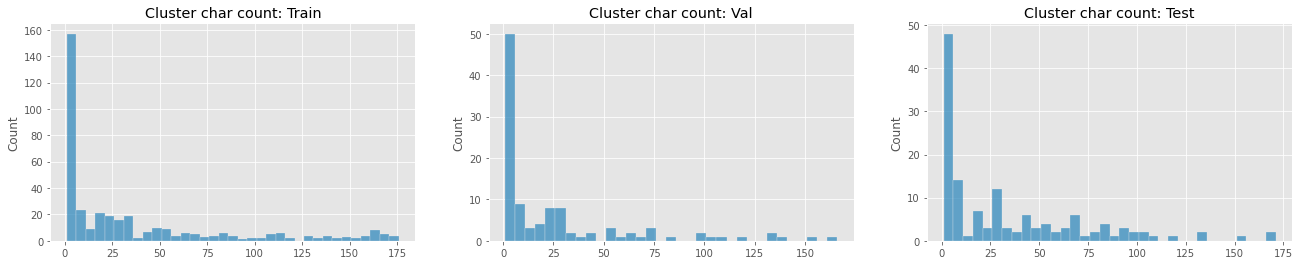

In [ ]:
def plot_cluster_count(df, data_name):
  sns.histplot(df['cluster'].values,binwidth=5)
  plt.title(f'Cluster char count: {data_name}')
  plt.grid(True)

plt.subplot(1, 3, 1)
plot_cluster_count(train_df, 'Train')

plt.subplot(1, 3, 2)
plot_cluster_count(val_df, 'Val')

plt.subplot(1, 3, 3)
plot_cluster_count(test_df, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

# Transformer building block

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)  

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [ ]:
class Defined_MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(Defined_MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = Defined_MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = Defined_MultiHeadAttention(d_model, num_heads)
    self.mha2 = Defined_MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self.dropout3 = layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

    

In [ ]:

def create_mlp(dim=30):
	# define our MLP network
	model = Sequential()
	model.add(Dense(dim, activation="relu"))
	model.add(Dense(dim, activation="relu"))

	return model

#Building transformer encoder+ MLP

In [ ]:
def build_t_encoder(
    num_layers,
    d_model,
    num_heads,
    dff,
    input_vocab_size,
    maximum_position_encoding,
    training=True,
    rate=0.1
):
    inputs = keras.layers.Input(shape=(30,))
    x=inputs
    enc_padding_mask = create_padding_mask(inputs)
    encoder = Encoder(num_layers, d_model, num_heads, dff,input_vocab_size, maximum_position_encoding, rate)
    x = encoder(x,training,enc_padding_mask)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    t_encoder = keras.Model(inputs, x)
    # for dim in mlp_units:
    #     x = layers.Dense(dim, activation="relu")(x)
    #     x = layers.Dropout(rate)(x)
    # outputs = layers.Dense(n_classes, activation="softmax")(x)
    return t_encoder

## CDR model

In [ ]:
def CDR_model(mlp_units,n_classes,rate=0.1,max_length=30):
    input1=keras.layers.Input(shape=(30,))
    input2=keras.layers.Input(shape=(30,))
    input3=keras.layers.Input(shape=(30,))
    input4=keras.layers.Input(shape=(30,))
    input5=keras.layers.Input(shape=(30,))
    input6=keras.layers.Input(shape=(30,))

    encoder1=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=256,input_vocab_size=21,maximum_position_encoding=max_length)(input1)
    encoder2=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=256,input_vocab_size=21,maximum_position_encoding=max_length)(input2)
    encoder3=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=256,input_vocab_size=21,maximum_position_encoding=max_length)(input3)
    encoder4=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=256,input_vocab_size=21,maximum_position_encoding=max_length)(input4)
    encoder5=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=256,input_vocab_size=21,maximum_position_encoding=max_length)(input5)
    encoder6=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=256,input_vocab_size=21,maximum_position_encoding=max_length)(input6)


    x = Concatenate()([encoder1, encoder2,encoder3, encoder4,encoder5, encoder6])
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(rate)(x)
    outputs = layers.Dense(n_classes, activation="sigmoid")(x)
    return keras.Model([input1,input2,input3,input4,input5,input6],outputs)

In [ ]:

CDR_model = CDR_model(mlp_units=[512,128,64],n_classes=1)
CDR_model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=METRICS,
)
CDR_model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

CDR_history=CDR_model.fit(
    [train_x1,train_x2,train_x3,train_x4,train_x5,train_x6], y_train,
    epochs=100, batch_size=256,
    validation_data=([val_x1,val_x2,val_x3,val_x4,val_x5,val_x6], y_val),
    callbacks=callbacks,
)


Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 input_38 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 input_39 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 30)]         0           []                               
                                                                                           

### Plot loss functions



In [ ]:
plt.style.use('ggplot')
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


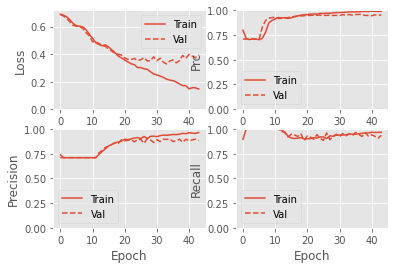

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(CDR_history)

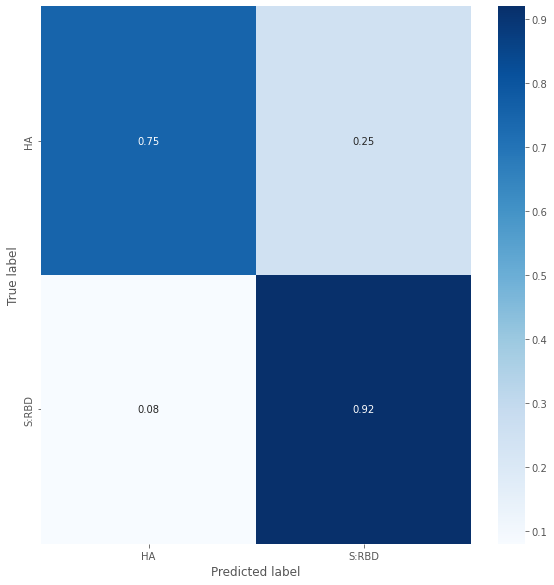

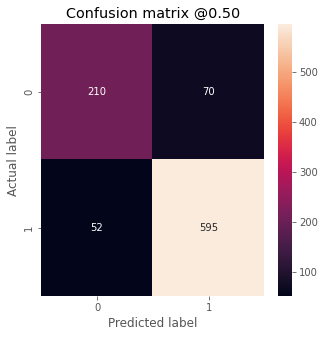

In [ ]:
y_pred=CDR_model.predict([test_x1,test_x2,test_x3,test_x4,test_x5,test_x6])

con_mat = confusion_matrix(y_test, y_pred >0.5)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = le.classes_, 
                     columns = le.classes_)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plot_cm(labels=y_test, predictions=y_pred)

## Saving model

In [ ]:
# saving model weights.
CDR_model.save('./Model/RBD_HA_CDR_model')
# load model
# CDR_model = keras.models.load_model('./Model/RBD_HA_CDR_model')

INFO:tensorflow:Assets written to: ./Model/RBD_HA_new_CDR_model/assets


INFO:tensorflow:Assets written to: ./Model/RBD_HA_new_CDR_model/assets


## Evaluate results

In [ ]:
# Utility function: Display model score(Loss & Accuracy and so on) across all sets.

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[5])
  print('Train Precision: ', train_score[6])
  print('Train Recall: ', train_score[7])
  print('Train AUC: ', train_score[8])
  print('Train PRC: ', train_score[9])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[5])
  print('Val Precision: ', val_score[6])
  print('Val Recall: ', val_score[7])
  print('Val AUC: ', val_score[8])
  print('Val PRC: ', val_score[9])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[5])
  print('Test Precision: ', test_score[6])
  print('Test Recall: ', test_score[7])
  print('Test AUC: ', test_score[8])
  print('Test PRC: ', test_score[9])

In [ ]:
display_model_score(CDR_model,
    [[train_x1,train_x2,train_x3,train_x4,train_x5,train_x6], y_train],
    [[val_x1,val_x2,val_x3,val_x4,val_x5,val_x6], y_val],
    [[test_x1,test_x2,test_x3,test_x4,test_x5,test_x6], y_test],
    256)


12/12 [==============================] - 1s 94ms/step - loss: 0.2019 - tp: 2015.0000 - fp: 140.0000 - tn: 721.0000 - fn: 87.0000 - accuracy: 0.9234 - precision: 0.9350 - recall: 0.9586 - auc: 0.9695 - prc: 0.9866
Train loss:  0.20186258852481842
Train accuracy:  0.9233884811401367
Train Precision:  0.9350348114967346
Train Recall:  0.9586108326911926
Train AUC:  0.9695322513580322
Train PRC:  0.9866031408309937
----------------------------------------------------------------------
3/3 [==============================] - 0s 90ms/step - loss: 0.3492 - tp: 497.0000 - fp: 69.0000 - tn: 146.0000 - fn: 29.0000 - accuracy: 0.8677 - precision: 0.8781 - recall: 0.9449 - auc: 0.9159 - prc: 0.9574
Val loss:  0.3491574227809906
Val accuracy:  0.8677462935447693
Val Precision:  0.8780918717384338
Val Recall:  0.9448668956756592
Val AUC:  0.915947437286377
Val PRC:  0.9574365019798279
----------------------------------------------------------------------
4/4 [==============================] - 0s 93ms

In [ ]:
#load model
CDR_model = keras.models.load_model('./Model/RBD_HA_CDR_model')

### Model evaluation and export on Spike-HA dataset

In [ ]:
def eval_model(model, train, val, test, batch_size):
  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  return [train_score,val_score,test_score]


In [ ]:
cdr_ls = eval_model(CDR_model,
    [[train_x1,train_x2,train_x3,train_x4,train_x5,train_x6], y_train],
    [[val_x1,val_x2,val_x3,val_x4,val_x5,val_x6], y_val],
    [[test_x1,test_x2,test_x3,test_x4,test_x5,test_x6], y_test],
    256)
cdr_df = pd.DataFrame(cdr_ls, columns =['loss','tp', 'fp' , 'tn','fn', 'accuracy','precision', 'recall','AUC','PRC'], index=['train set','val set','test set'],dtype = float) 

4/4 [==============================] - 0s 91ms/step - loss: 0.3499 - tp: 600.0000 - fp: 74.0000 - tn: 206.0000 - fn: 47.0000 - accuracy: 0.8695 - precision: 0.8902 - recall: 0.9274 - auc: 0.9184 - prc: 0.9600


In [ ]:

cdr_df.to_csv('result/evaluation/RBD-HA_CDR_model_evaluation.csv')

### Prediction on Momsen and HIV dataset

In [ ]:
data_path = 'data/Momsen_HIV_Abs.xlsx'
Momsen_df = pd.read_excel(data_path)

[Momsen_test_x1,Momsen_test_x2,Momsen_test_x3,Momsen_test_x4,Momsen_test_x5,Momsen_test_x6]=encode_six_CDR(Momsen_df)

print(Momsen_test_x1.shape)


(162, 30)


In [ ]:
y_pred=CDR_model.predict([Momsen_test_x1,Momsen_test_x2,Momsen_test_x3,Momsen_test_x4,Momsen_test_x5,Momsen_test_x6])
# print(y_pred)

Momsen_df['probability_Spike']=pd.Series(y_pred.flatten())
Momsen_df['Prediction']=np.where(Momsen_df['probability_Spike'] > 0.5, 'Spike', 'HA')
Momsen_df.to_excel('result/evaluation/Momsen_HIV_Abs_prediction_by_RBD-HA_model.xlsx')

## Test on HIV dataset

In [ ]:
data_path = 'data/HIV_Abs_from_GB_v4_full_CDR.xlsx'

raw_df = pd.read_excel(data_path)
raw_df=raw_df[raw_df[['CDRH1_AA','CDRL1_AA','CDRH2_AA','CDRL2_AA','CDRH3_AA','CDRL3_AA']].notnull().all(1)]
cleaned_df = raw_df[['Name','CDRH1_AA','CDRL1_AA','CDRH2_AA','CDRL2_AA','CDRH3_AA','CDRL3_AA','VH Genbank ID','VL Genbank ID']].copy()

#deduplication
HIV_df = cleaned_df.drop_duplicates(subset=['CDRH1_AA','CDRL1_AA','CDRH2_AA','CDRL2_AA','CDRH3_AA','CDRL3_AA'])

[HIV_test_x1,HIV_test_x2,HIV_test_x3,HIV_test_x4,HIV_test_x5,HIV_test_x6]=encode_six_CDR(HIV_df)

HIV_y_pred=CDR_model.predict([HIV_test_x1,HIV_test_x2,HIV_test_x3,HIV_test_x4,HIV_test_x5,HIV_test_x6])
# print(HIV_y_pred)
HIV_df=HIV_df.reset_index()
HIV_df['probability_Spike']=pd.Series(HIV_y_pred.flatten())
print(HIV_df['probability_Spike'])
HIV_df['Prediction']=np.where(HIV_df['probability_Spike'] > 0.5, 'Spike', 'HA')

HIV_df.to_excel('./result/evaluation/HIV_dataset_prediction_by_RBD-HA_model.xlsx')

0      0.593477
1      0.974983
2      0.092957
3      0.064527
4      0.534932
         ...   
686    0.187647
687    0.977179
688    0.996910
689    0.996684
690    0.512793
Name: probability_Spike, Length: 691, dtype: float32
